# Cohort Analysis with Python

### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

### Read Data

In [4]:
df = pd.read_csv('online_retail.csv')

In [5]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
print('The dataframe contains', len(df), 'rows')

The dataframe contains 541909 rows


In [7]:
print(df.dtypes)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


### Data Cleaning

In [8]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Due to the dataset's large size all rows with null values in the *CustomerID* column will be dropped.

In [9]:
df.dropna(subset=['CustomerID'], inplace=True)

### Convert  *InvoiceDate*  to datetime

In [10]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

### Cohort Analysis

Extract the year - month from from the *InvoiceDate* column

In [11]:
df['InvoiceMonth'] = df['InvoiceDate'].apply(lambda invoice_date: dt.datetime(invoice_date.year, invoice_date.month, 1))

In [12]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


Create a new column *CohortMonth* to identify the cohort month for each customer, meaning the month in which a particular customer made their first purchase or transaction.

In [13]:
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

Calculate the difference between the *InvoiceMonth* and *CohortMonth* to get cohort index

In [14]:
def cohort_index(df, invoice_date, cohort_date):
    invoice_year = pd.to_datetime(df[invoice_date]).dt.year
    invoice_month = pd.to_datetime(df[invoice_date]).dt.month
    cohort_year = pd.to_datetime(df[cohort_date]).dt.year
    cohort_month = pd.to_datetime(df[cohort_date]).dt.month
    
    return (invoice_year - cohort_year) * 12 + invoice_month - cohort_month

In [15]:
df['CohortIndex'] = cohort_index(df, 'InvoiceMonth', 'CohortMonth')

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0


### Create Cohort Counts Table Based on *CustomerID*

Group by *CohortMonth* and *CohortIndex*.

In [17]:
grouped_df = df.groupby(['CohortMonth', 'CohortIndex'])

Calculate unique customer count for each cohort index and reset the index

In [18]:
cohort_data = grouped_df['CustomerID'].apply(pd.Series.nunique).reset_index()

Create the cohort counts table where each cell contains the count of unique customers for each combination of cohort month and cohort index. This table provides a clear visualization of how many customers from each cohort group (formed in a specific month) are still active or engaged over time.

In [19]:
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

In [20]:
cohort_sizes = cohort_counts.iloc[:,0]

retention = cohort_counts.divide(cohort_sizes, axis=0)

In [21]:
retention

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02-01,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03-01,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04-01,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Heatmap visualization

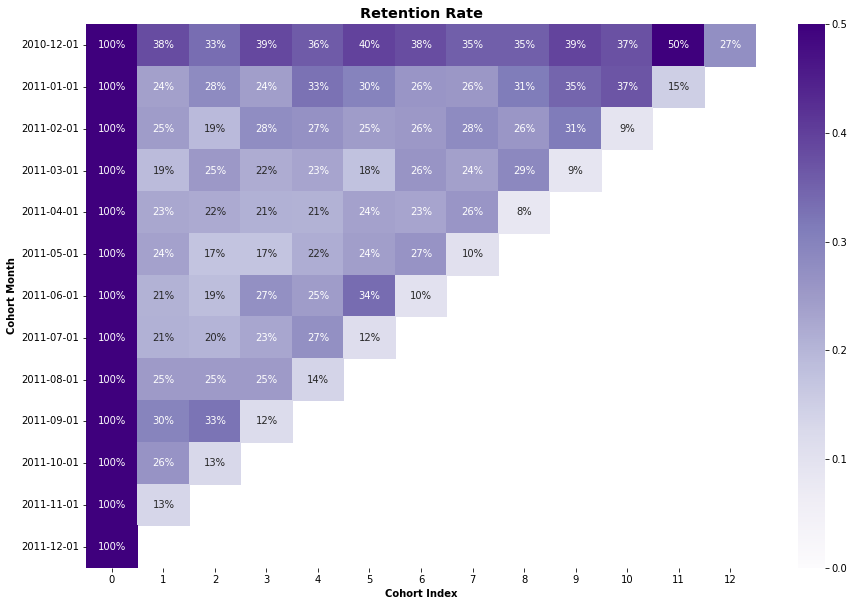

In [22]:
plt.figure(figsize=(15,10))

ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin= 0.0, vmax=0.5, cmap='Purples')

ticklabels = [retention.index[int(tick)].strftime('%Y-%m-%d') for tick in ax.get_yticks()]

ax.set_ylim(13.0,0)
ax.set_yticklabels(ticklabels)

ax.set_title('Retention Rate', fontsize='x-large', fontweight='heavy')

ax.set_xlabel('Cohort Index', fontweight='bold')
ax.set_ylabel('Cohort Month', fontweight='bold')

plt.show()